In [3]:
import numpy as np 
import seaborn as sns 
from os import listdir 
import tensorflow as tf
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model, load_model 
from tensorflow.keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,InputLayer,Flatten, Dropout, Dense,Activation


In [4]:
!pip install split-folders #for spliting dataset with a given ratio

In [6]:
import splitfolders 
IMAGE_SIZE = 256
BATCH_SIZE =8
EPOCHS = 60 
CHANNELS=3 
LR = 1e-4


In [8]:
splitfolders.ratio('/content/drive/MyDrive/mango leaves', output="/content/drive/MyDrive/mango", seed=1335, ratio=(0.8, 0.1,0.1))


ValueError: The provided input folder "/content/drive/MyDrive/mango leaves" does not exists.

In [16]:
Image_Generator = ImageDataGenerator( horizontal_flip=True, rotation_range=10,
rescale=1.0/255, shear_range=0.2, zoom_range=0.3,
fill_mode="reflect"
                                    )

In [17]:
train_generator=Image_Generator.flow_from_directory( '/kaggle/input/apple-disease-identification/apple check/train/train', target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE,
class_mode='sparse', color_mode="rgb", shuffle=True, seed=123
)


Found 1902 images belonging to 5 classes.


In [18]:
val_datagen=ImageDataGenerator( rescale=1.0/255,
)
val_generator=val_datagen.flow_from_directory( '/kaggle/input/apple-disease-identification/apple check/val/val', target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE,
color_mode="rgb", class_mode="sparse", shuffle=True, seed=123
)


Found 236 images belonging to 5 classes.


In [19]:
test_datagen=ImageDataGenerator( rescale=1.0/255,
)
test_generator=test_datagen.flow_from_directory( '/kaggle/input/apple-disease-identification/apple check/test/test', target_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE,
color_mode="rgb",
class_mode="sparse",
                                               )

Found 243 images belonging to 5 classes.


In [24]:
class_names=['Apple Scab','Block rot','Healthy','Mosaic','Powdery Mildew']

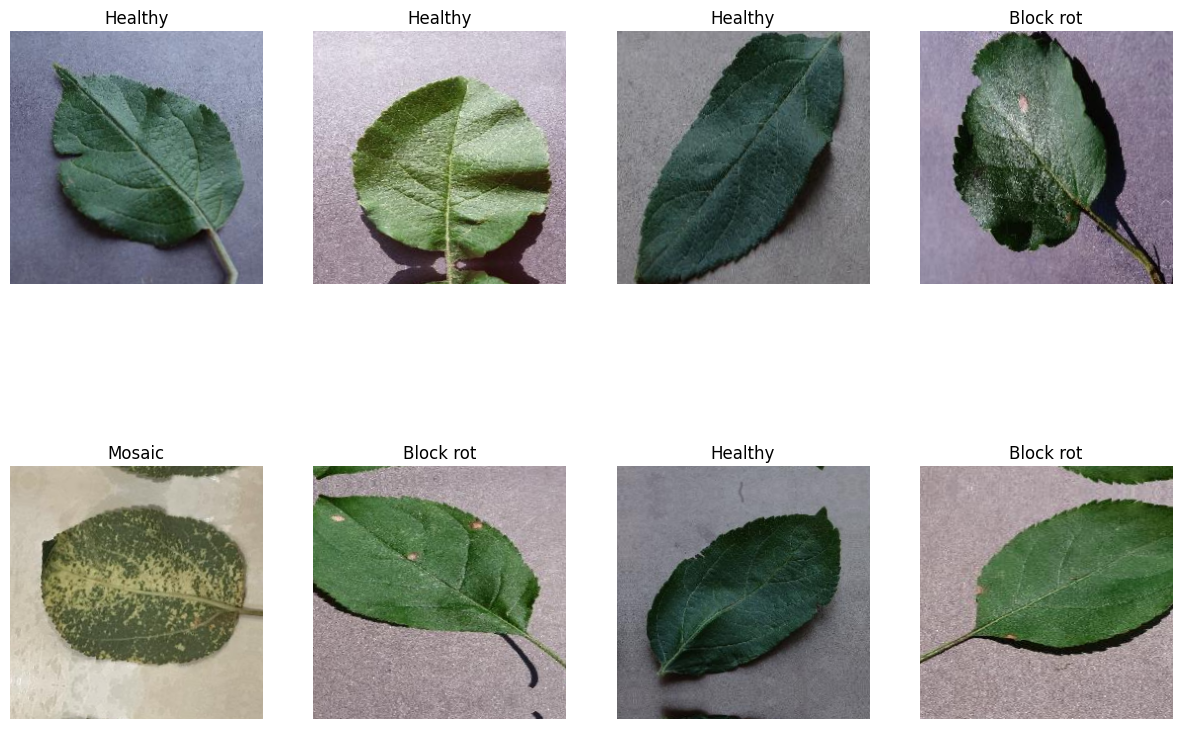

In [25]:
plt.figure(figsize=(15,16))
for image_batch,label_batch in train_generator: 
    for i in range(8):
        plt.subplot(3,4,i+1) 
        plt.imshow((image_batch[i]*255).astype(np.uint8)) 
        plt.title( class_names[int(label_batch[i])]) 
        plt.axis('off')
    break


In [26]:
input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model =Sequential([ InputLayer(input_shape=input_shape),
Conv2D(32, (3,3),padding='same', activation='relu'), MaxPooling2D((2, 2)),

Conv2D(64, (3,3),padding='same', activation='relu'), MaxPooling2D((2, 2)),

Conv2D(128, (3,3),padding='same', activation='relu'), MaxPooling2D((2, 2)),

Conv2D(256, (3,3), padding='same',activation='relu'),
MaxPooling2D((2, 2)),

Conv2D(512, (3, 3),padding='same',activation='relu'),
MaxPooling2D((2, 2)),

Conv2D(1024, (3, 3),padding='same',activation='relu'),
MaxPooling2D((2, 2)), Dropout(0.5),

Conv2D(1024, (3, 3),padding='same',activation='relu'),
MaxPooling2D((2, 2)), Dropout(0.5),

Flatten(),

Dense(1024,activation='relu'),
Dense(128,activation='relu'),
Dense(64,activation='relu'),

Dense(5,activation='softmax')
                  ])

In [27]:
model.summary()# summary of model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

In [31]:
from tensorflow.keras.optimizers import Adam

# Other callbacks definitions
model_check_point = ModelCheckpoint(filepath="/content/drive/MyDrive/best_model.h5", 
                                    monitor="val_loss",
                                    verbose=0, 
                                    save_best_only=True)
early_stop = EarlyStopping(monitor="val_accuracy", patience=30, verbose=1) 
log_csv = CSVLogger('/content/drive/MyDrive/my_logs.csv', separator=',', append=False) 
call_backs = [model_check_point, early_stop, log_csv]

# Use the legacy Adam optimizer
opt = tf.keras.optimizers.legacy.Adam(learning_rate=LR, decay=LR/EPOCHS)


In [32]:
model.compile( optimizer=opt,
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [34]:
steps_per_epoch=int((train_generator.samples)/BATCH_SIZE) 
validation_step=int((val_generator.samples)/BATCH_SIZE) 
steps_per_epoch,validation_step

(237, 29)

In [35]:
history=model.fit( train_generator, verbose=1, epochs=EPOCHS, callbacks=call_backs, batch_size=BATCH_SIZE,
validation_data=val_generator, steps_per_epoch=steps_per_epoch, validation_steps=validation_step

)


Epoch 1/60
237/237 [==============================] - ETA: 0s - loss: 1.5022 - accuracy: 0.2899

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


237/237 [==============================] - 256s 1s/step - loss: 1.5022 - accuracy: 0.2899 - val_loss: 1.0595 - val_accuracy: 0.4483
Epoch 2/60
237/237 [==============================] - 258s 1s/step - loss: 0.9364 - accuracy: 0.5744 - val_loss: 0.7485 - val_accuracy: 0.6724
Epoch 3/60
237/237 [==============================] - 259s 1s/step - loss: 0.7770 - accuracy: 0.6753 - val_loss: 0.8568 - val_accuracy: 0.6121
Epoch 4/60
237/237 [==============================] - 259s 1s/step - loss: 0.6477 - accuracy: 0.7423 - val_loss: 0.5586 - val_accuracy: 0.7888
Epoch 5/60
237/237 [==============================] - 259s 1s/step - loss: 0.5008 - accuracy: 0.7999 - val_loss: 0.3916 - val_accuracy: 0.8276
Epoch 6/60
237/237 [==============================] - 258s 1s/step - loss: 0.4315 - accuracy: 0.8231 - val_loss: 0.6115 - val_accuracy: 0.8233
Epoch 7/60
237/237 [==============================] - 257s 1s/step - loss: 0.3411 - accuracy: 0.8638 - val_loss: 0.3400 - val_accuracy: 0.8707
Epoch 8/60

In [36]:
model.evaluate(test_generator)

31/31 [==============================] - 7s 229ms/step - loss: 0.0426 - accuracy: 0.9918


[0.042604152113199234, 0.991769552230835]

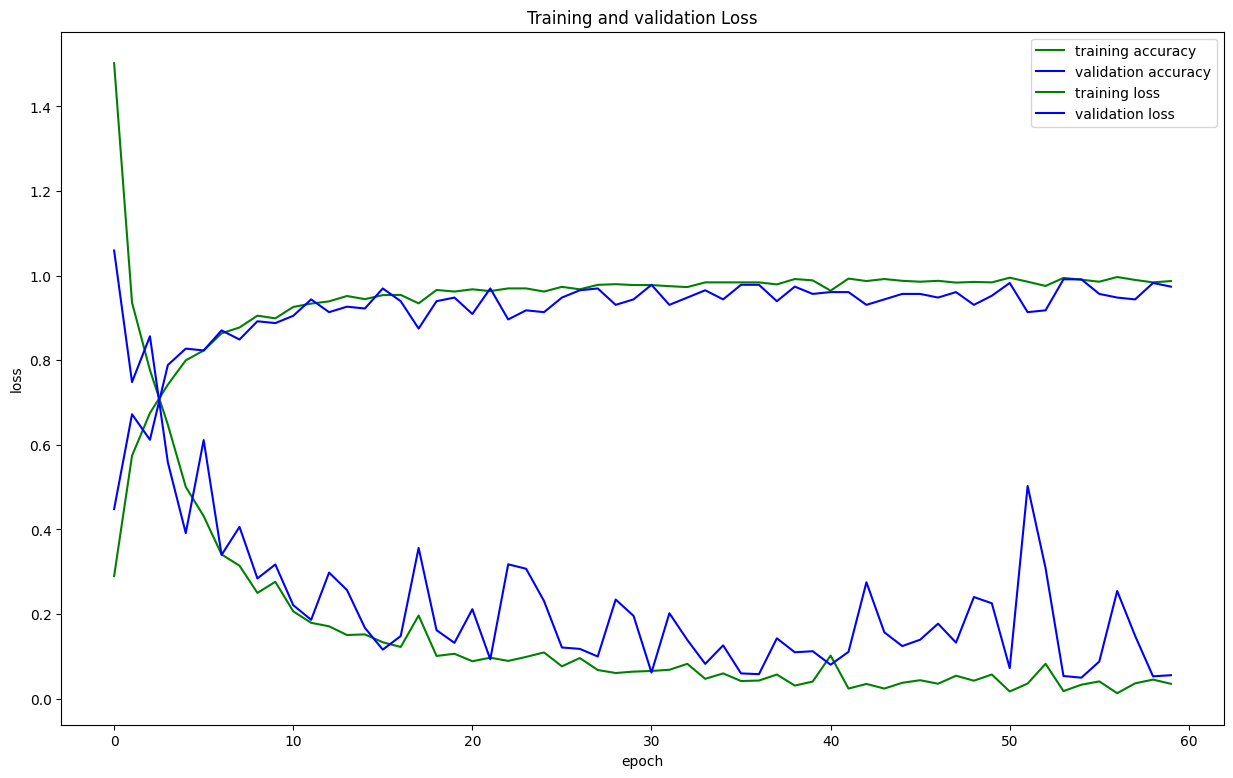

In [39]:
acc=history.history['accuracy'] 
val_acc=history.history['val_accuracy'] 
loss=history.history['loss'] 
val_loss=history.history['val_loss']

plt.figure(figsize=(15,9)) #accuracy graph plt.subplot(1,2,1)
plt.plot(acc,'g',label='training accuracy') 
plt.plot(val_acc,'b',label='validation accuracy') 
plt.legend(loc='lower right') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and validation Accuracy')

#loss graph plt.subplot(1,2,2)
plt.plot(loss,'g',label='training loss') 
plt.plot(val_loss,'b',label='validation loss') 
plt.legend(loc='upper right') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and validation Loss') 
plt.show()


In [38]:
model.save('my_model.h5')

In [44]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Assuming you have trained and saved your quantization-aware model
# If you haven't trained it yet, replace this line with your training code.
# For example:
# q_aware_model = train_quantization_aware_model()

# Load the quantization-aware model
q_aware_model = load_model('my_model.h5')

# Create a TensorFlow Lite converter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

# Set optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to TensorFlow Lite format
tflite_qaware = converter.convert()


In [46]:
with open("optimized_tflite_model.tflite", 'wb') as f:
    f.write(tflite_qaware)
